# Aula 2 - Fastai
## *Exemplo ursos*

* ### Importação das bibliotecas

In [2]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

* ### Download das imagens de ursos pardos para formar o conjunto de dados

In [4]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

In [5]:
ims = search_images_ddg('grizzly bear')
len(ims)

200

* ### Visualização de uma "imagem exemplo"

In [6]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest, show_progress=False)

Path('images/grizzly.jpg')

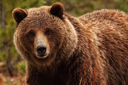

In [7]:
im = Image.open(dest)
im.to_thumb(128,128)

* ### Baixando imagens para cada tipo de urso e as separando em suas respectivas pastas

In [8]:
bear_types = 'grizzly', 'black', 'teddy'
path = Path('bears')

In [9]:
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

In [10]:
fns = get_image_files(path)
fns

(#529) [Path('bears/black/01a8be41-c585-4180-ae7c-a8d370cf4291.jpg'),Path('bears/black/064f67a5-74be-42aa-a644-8a57728db196.jpg'),Path('bears/black/07629331-2f23-4d52-ba77-01c0b9a07b6a.png'),Path('bears/black/0a6700e9-c549-49a5-bffc-0d6f7ed310ee.JPG'),Path('bears/black/0c94017c-5d10-4d58-aef4-429509a2f126.jpg'),Path('bears/black/0d259620-7d06-4a4d-a124-4b909e6a197d.JPG'),Path('bears/black/0decc5c2-b1a6-48f6-8500-f2867d1f00f5.jpg'),Path('bears/black/1039a4e0-3aa6-4dbe-9523-83097a2ef6d0.jpg'),Path('bears/black/11f338f6-9139-484e-9cdf-20168a7adbd2.jpg'),Path('bears/black/1286d673-04ee-424b-ac60-05ad23dce75b.jpg')...]

In [11]:
failed = verify_images(fns)
failed

(#0) []

In [12]:
failed.map(Path.unlink)

(#0) []

* ### Treinando o modelo

In [13]:
class DataLoaders(GetAttr):
    def _init_(self, *loaders): self.loaders = loaders
    def _getitem_(self, i): return self.loaders[i]
    train, valid = add_props(lambda i, slf: self[i])

In [14]:
'''
Dataloaders:

Com quais tipos de dados estamos trabalhando
Como obter a lista de itens
Como rotular esses itens
Como criar o conjunto de validação
'''

bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [15]:
dls = bears.dataloaders(path)

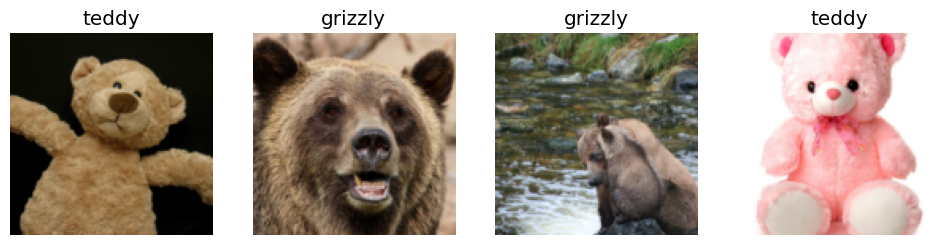

In [16]:
dls.valid.show_batch(max_n=4, nrows=1)

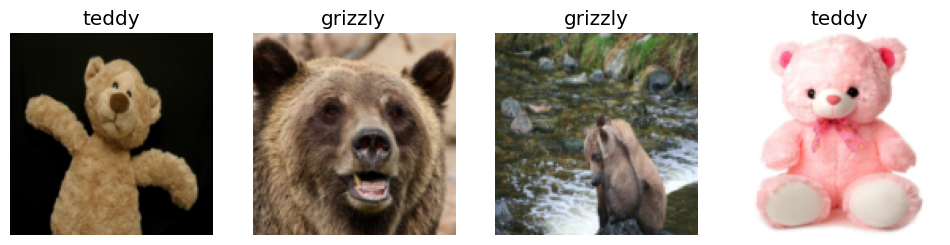

In [17]:
#Squish - afina a imagem para mostrar toda a informação

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

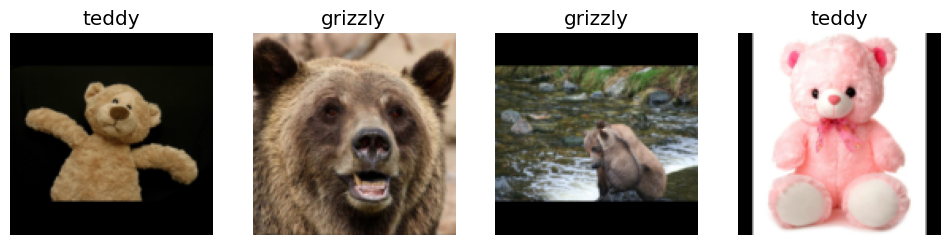

In [18]:
# pad - proporção correta sem afinamento mas preenchimento de barras

bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

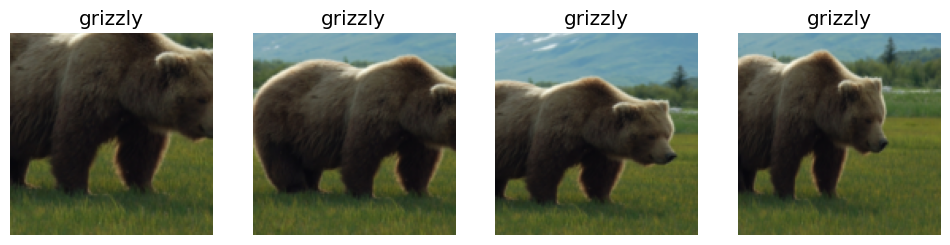

In [19]:
# random resize crop - gera a mesma imagem com diversas proporções "aumento de dados"

bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

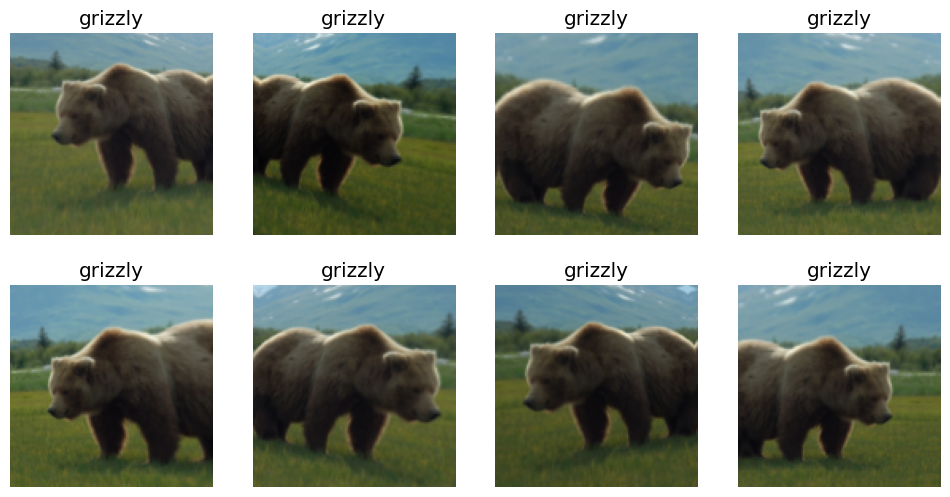

In [20]:
# aug_transforms - muda saturação, cor, distorce, etc "Aumento de dados"

bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms())
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [21]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [22]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

C:\Users\nebia\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nebia\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.257585,0.290942,0.066667,00:42


epoch,train_loss,valid_loss,error_rate,time
0,0.182759,0.315758,0.057143,00:50
1,0.135767,0.429675,0.066667,00:51
2,0.102996,0.443246,0.057143,00:50
3,0.089748,0.439022,0.066667,00:48


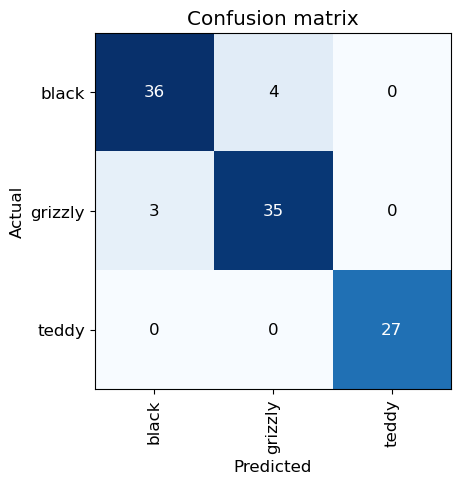

In [23]:
# Matriz de confusão

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

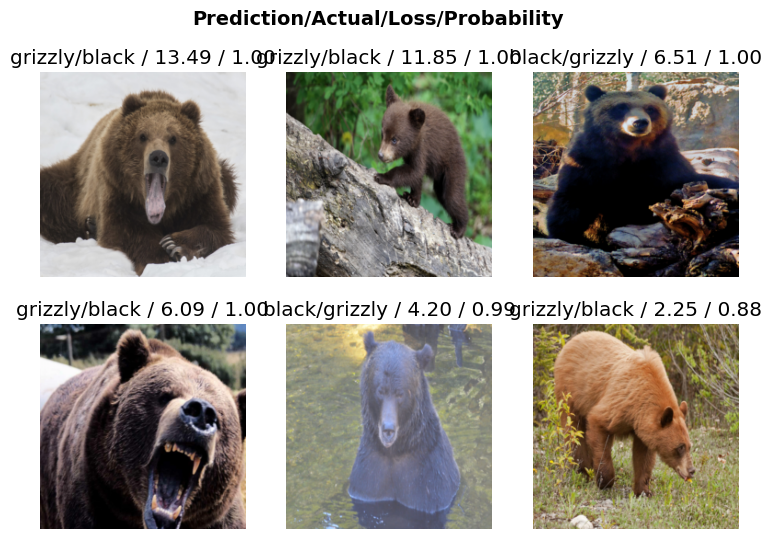

In [24]:
# perdas - [confiante e errado] [certo e inseguro]

interp.plot_top_losses(6, nrows=2)

In [25]:
# Primeiro treinamos o modelo para depois limpá-lo (inconsistências e inseguranças do modelo)
#ImageClassifierCleaner - limpar rótulos incorretos do conj. de dados

cleaner = ImageClassifierCleaner(learn)
cleaner

In [26]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

* ### Exportando o modelo e utilizando-o

In [27]:
# export - download do arquivo contendo o modelo treinado

learn.export('model_bears.pkl')

In [28]:
learn_inf = load_learner('model_bears.pkl')

In [29]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([4.8334e-04, 9.9951e-01, 5.0060e-06]))

In [30]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

* ### Utilizando o modelo em uma mini aplicação

In [31]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [33]:
img = PILImage.create(btn_upload.data[-1])

In [34]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [35]:
pred, pred_idx, probs = learn_inf.predict(img)

In [36]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9997')

In [37]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [38]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred, pred_idx, probs = learn_inf.predict(img)
    lbl_pred.value = f'Predicition: {pred}; Probability: {probs[pred_idx]:.04f}'
    
btn_run.on_click(on_click_classify)

In [39]:
btn_upload = widgets.FileUpload()

In [40]:
VBox([widgets.Label('Select your bear!'),
     btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
#doc(função) - atalho para documentação
#??função - breve explicação